In [2]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

In [12]:
# hipermarametros

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 100
epsilon_std = 0.7

In [13]:
# create incoder

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(lambda args: args[0] + K.random_normal(shape=(K.shape(args[0])[0], latent_dim), mean=0., stddev=epsilon_std) * K.exp(args[1] / 2), output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

In [14]:
# create sampling function

def sampling(args: tuple):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [15]:
# create decoder

input_decoder = Input(shape=(latent_dim,), name="decoder_input")

decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)

x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")

In [16]:
# create vae
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# loss function
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

vae.add_loss(K.mean(kl_loss) / original_dim)
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [18]:
# dataloads

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [19]:
# train
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/100
600/600 [==============================] - 3s 4ms/step - loss: 0.2839 - val_loss: 0.2473
Epoch 2/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2440 - val_loss: 0.2400
Epoch 3/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2381 - val_loss: 0.2346
Epoch 4/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2336 - val_loss: 0.2310
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2305 - val_loss: 0.2283
Epoch 6/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2285 - val_loss: 0.2266
Epoch 7/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2270 - val_loss: 0.2253
Epoch 8/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2257 - val_loss: 0.2240
Epoch 9/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2245 - val_loss: 0.2228
Epoch 10/100
600/600 [==============================] - 2s 4ms/step - loss: 0.2233 - val_lo

1/1 [==============================] - 0s 11ms/step


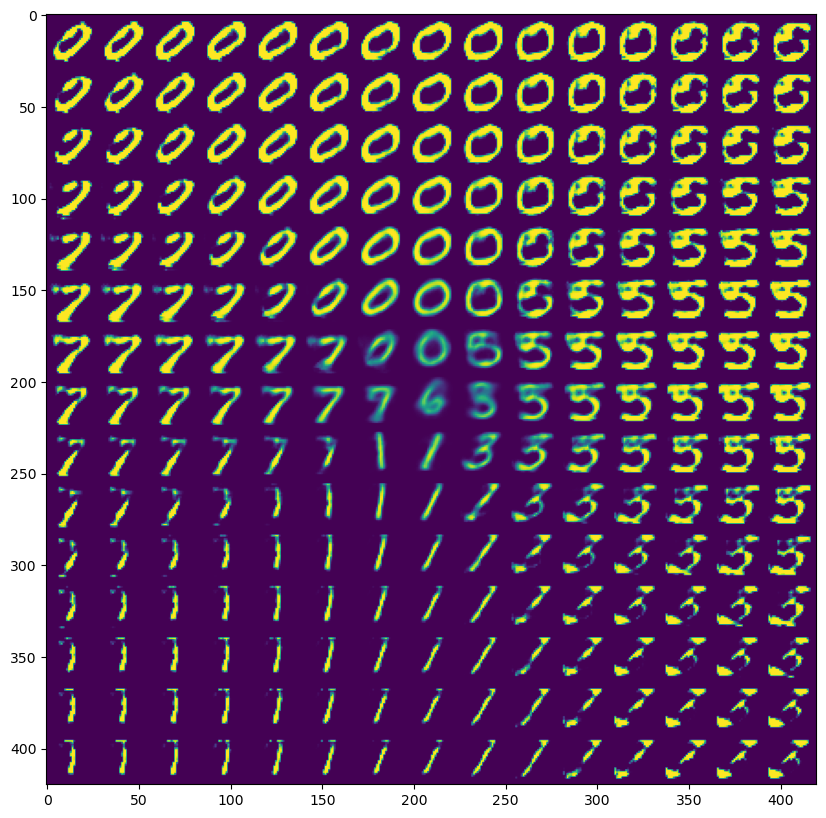

In [20]:
# show results
import matplotlib.pyplot as plt

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
